In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from BinanceCollector import BinanceCollector
from TradeBook import TradeBook
import warnings
warnings.filterwarnings("ignore")
from BreakdownCalculator import BreakdownCalculator
from BinanceSync import BinanceSync
from sklearn.model_selection import train_test_split
from tensorflow import keras
from HyperBacktest import HyperBacktest
import matplotlib.pyplot as plt
import quantstats as qs
from datetime import datetime,timedelta

c:\Users\deves\AppData\Local\Programs\Python\Python37\lib\site-packages\requests\__init__.py:114: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning,


In [2]:
symbol = "SOLUSDT"
collector = BinanceCollector(symbol,"2022-01-01","2023-01-02","15m")
collector.start_collect()
collector.df.columns = ["Open Time","Open","High","Low","Close","Volume","Close Time",
             "Quote asset volumne","Total Trades","Buyer Base Volume",
             "Taker buy quote asset volume","Ignore"]
df = collector.df
breakdown = BinanceCollector(symbol,"2022-01-01","2023-01-02","1m")
breakdown.start_collect()
breakdown.df.columns = ["Open Time","Open","High","Low","Close","Volume","Close Time",
             "Quote asset volumne","Total Trades","Buyer Base Volume",
             "Taker buy quote asset volume","Ignore"]
breakdown_df = breakdown.df
calculator = BreakdownCalculator(breakdown_df)

In [3]:
df["Open Time"] = pd.to_datetime(df["Open Time"],unit="ms")
df["Close Time"] = pd.to_datetime(df["Close Time"]+1,unit="ms")
open_time = df["Open Time"]

In [4]:
df["EMA_20"] = df["Close"].ewm(span=20,adjust=False).mean()
df["EMA_50"] = df["Close"].ewm(span=50,adjust=False).mean()
df["EMA_200"] = df["Close"].ewm(span=200,adjust=False).mean()

df = df[["Open","High","Low","Close","EMA_20","EMA_50","EMA_200","Open Time"]]

# Normalising Data
# df = (df - df.mean())/df.std()

In [5]:
# Filter dataframe for month
# df = df[df["Open Time"].dt.month == 4]
# df.reset_index(inplace=True)

In [6]:
df["Buy"] = np.where( (df["EMA_20"] > df["EMA_50"]) & (df["EMA_20"].shift(1) <= df["EMA_50"].shift(1) ),1,0 )
df["Sell"] = np.where( (df["EMA_20"] < df["EMA_50"]) & (df["EMA_20"].shift(1) >= df["EMA_50"].shift(1) ),1,0 )
df["Returns"] = 0

In [7]:
main = df.copy()
main.tail()

,Open,High,Low,Close,EMA_20,EMA_50,EMA_200,Open Time,Buy,Sell,Returns
34765,9.99,10.01,9.97,9.97,9.973550,9.940877,9.878851,2023-01-01 22:45:00,0,0,0
34766,9.98,10.06,9.98,10.02,9.977973,9.943980,9.880255,2023-01-01 23:00:00,0,0,0
34767,10.02,10.03,9.96,9.97,9.977214,9.945000,9.881148,2023-01-01 23:15:00,0,0,0
34768,9.97,9.99,9.96,9.98,9.977479,9.946373,9.882132,2023-01-01 23:30:00,0,0,0
34769,9.98,10.00,9.95,9.99,9.978672,9.948083,9.883205,2023-01-01 23:45:00,0,0,0


In [14]:
df = main.copy()
leverage = 1
backtest = HyperBacktest(4,-2,calculator,df,leverage=leverage)
backtest.run()
df = backtest.df
# calculate total portfolio value
start_balance = 20
df["Compounded Returns"] = (1 + df["Returns"]/100).cumprod()
df["Portfolio Value"] = df["Compounded Returns"] * start_balance
tmp = df.copy()
tmp = tmp.set_index("Open Time")
qs.reports.html(tmp["Returns"]/100, output="report.html",download_filename=f"report-{symbol}.html", title=f"Report {symbol} ({leverage}x leverage)")

Before Drop: 577
After Drop: 498


<AxesSubplot:>

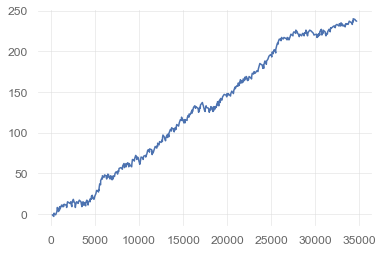

In [15]:
df["Returns"].cumsum().plot()
# df["Portfolio Value"].plot(figsize=(20,5))
# len(df[df["Returns"] != 0])

Text(0.5, 1.0, 'Monthly Returns SOLUSDT (1x)')

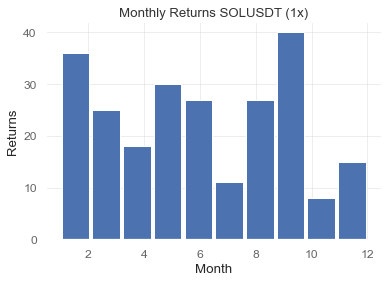

In [16]:
# Calculate monthly returns
returns = []
months = []
for i in range(1,13):
    months.append(i)
    r = df["Returns"][df["Open Time"].dt.month == i].sum()
    returns.append(r)

plt.hist(months,weights=returns,rwidth=0.9)
plt.xlabel("Month")
plt.ylabel("Returns")
plt.title(f"Monthly Returns {symbol} ({leverage}x)")

In [18]:
df.tail()

,Open,High,Low,Close,EMA_20,EMA_50,EMA_200,Open Time,Buy,Sell,Returns,End,Gap,Compounded Returns,Portfolio Value
34296,11.03,11.06,11.02,11.06,11.017771,11.016329,11.177761,2022-12-28 00:30:00,1,0,-1,2022-12-28 03:02:00,695.0,9.068854,181.377076
34298,11.01,11.03,10.88,10.91,11.006837,11.011921,11.173444,2022-12-28 01:00:00,0,1,4,2022-12-28 05:15:00,625.0,9.431608,188.632159
34515,9.15,9.19,9.09,9.12,9.369460,9.375468,9.696642,2022-12-30 07:45:00,0,1,-1,2022-12-30 12:33:00,3163.0,9.337292,186.745838
34537,9.60,9.69,9.56,9.61,9.307398,9.300055,9.602939,2022-12-30 13:15:00,1,0,-1,2022-12-30 14:49:00,3360.0,9.243919,184.878380
34691,9.89,9.90,9.85,9.88,9.981980,9.986409,9.857212,2023-01-01 04:15:00,0,1,-1,2023-01-01 23:44:00,2382.0,9.151480,183.029596


In [29]:
df[ (df["Buy"] == 1) & (df["Returns"] < 0) ]

,index,Open,High,Low,Close,EMA_20,EMA_50,EMA_200,Open Time,Buy,Sell,Returns
307,8857,3505.14,3507.83,3502.55,3506.14,3501.574118,3501.296832,3476.249506,2022-04-04 05:45:00,1,0,-2
366,8916,3503.59,3517.10,3496.86,3516.16,3470.294027,3469.719705,3473.258521,2022-04-04 20:30:00,1,0,-1
604,9154,3220.03,3224.70,3216.22,3224.47,3215.264899,3215.258351,3308.378970,2022-04-07 08:45:00,1,0,-1
607,9157,3206.67,3230.66,3206.67,3225.37,3215.271910,3215.231805,3305.616019,2022-04-07 09:30:00,1,0,-1
723,9273,3266.93,3304.00,3261.23,3290.92,3260.327884,3259.614853,3266.898704,2022-04-08 14:45:00,1,0,-1
901,9451,3244.39,3256.38,3244.38,3251.78,3244.760490,3244.577499,3241.089215,2022-04-10 11:45:00,1,0,-1
1076,9626,3025.23,3033.68,3018.63,3031.09,3007.570776,3006.542675,3096.788943,2022-04-12 08:00:00,1,0,-1
1195,9745,3079.11,3084.00,3070.83,3081.16,3039.939688,3038.661830,3053.369081,2022-04-13 14:00:00,1,0,-1
1556,10106,3048.46,3049.00,3044.93,3046.19,3041.384669,3041.275681,3040.056740,2022-04-17 09:15:00,1,0,-2
1607,10157,3054.84,3073.74,3041.00,3072.44,3050.088614,3049.787626,3044.712445,2022-04-17 22:00:00,1,0,-1


In [71]:
# Optimizing data for profitable buy signals
x = df[ df["Buy"] == 1 ]
y = np.where( x["Returns"] > 2,1 ,0 )
x = x[["Open","High","Low","Close","EMA_20","EMA_50","EMA_200"]]

In [72]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)
x_train = np.reshape( np.array(x_train), (x_train.shape[0],1,x_train.shape[1]) )
x_test = np.reshape( np.array(x_test), (x_test.shape[0],1,x_test.shape[1]) )

In [130]:
model = keras.Sequential([
    keras.layers.GRU(12,return_sequences=True,input_shape=(1,7)),
    keras.layers.Dense(8,activation="relu"),
    keras.layers.Dense(4,activation="tanh"),
    keras.layers.Dense(2),
    keras.layers.Softmax()
])

# keras.losses.c

model.compile(optimizer="ftrl",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
model.fit(x_train,y_train,epochs=10)

Train on 260 samples
Epoch 1/10
260/260 [==============================] - 2s 6ms/sample - loss: 0.7050 - acc: 0.7188
Epoch 2/10
260/260 [==============================] - 0s 200us/sample - loss: 0.6902 - acc: 0.8046
Epoch 3/10
260/260 [==============================] - 0s 169us/sample - loss: 0.6890 - acc: 0.8046
Epoch 4/10
260/260 [==============================] - 0s 169us/sample - loss: 0.6879 - acc: 0.8012
Epoch 5/10
260/260 [==============================] - 0s 192us/sample - loss: 0.6870 - acc: 0.8012
Epoch 6/10
260/260 [==============================] - 0s 181us/sample - loss: 0.6861 - acc: 0.8012
Epoch 7/10
260/260 [==============================] - 0s 181us/sample - loss: 0.6854 - acc: 0.8080
Epoch 8/10
260/260 [==============================] - 0s 173us/sample - loss: 0.6848 - acc: 0.8012
Epoch 9/10
260/260 [==============================] - 0s 154us/sample - loss: 0.6841 - acc: 0.8080
Epoch 10/10
260/260 [==============================] - 0s 165us/sample - loss: 0.6836 - ac

In [131]:
model.evaluate(x_test,y_test)

65/65 [==============================] - 1s 23ms/sample - loss: 0.6849 - acc: 0.7653


[0.684859459216778, 0.76525134]

In [138]:
tmp = x_train[3]
tmp_r = y_train[3]
tmp = np.reshape(tmp,(1,1,7))

In [139]:
model.predict(tmp)

array([[[0.50829697, 0.491703  ]]], dtype=float32)

In [29]:
df = df.set_index("Open Time")
# df = df[ df["Returns"] != 0 ]

In [32]:
qs.reports.html(df["Returns"]/100, output="report.html",download_filename=f"report-{symbol}.html", title=f"Report {symbol}")

In [93]:
trades = df[ df["Buy"] == 1 ]
trades.reset_index(inplace=True)

In [94]:
trades["Gap"] = (trades["Open Time"] - trades["End"].shift(1).fillna(datetime.now())).apply(lambda x: x.total_seconds()/60)
trades = trades[1:]

<AxesSubplot:>

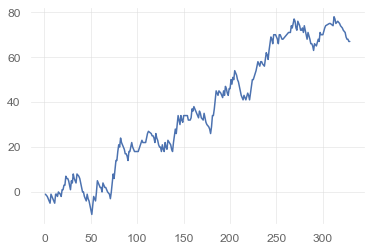

In [95]:
trades[ trades["Gap"] >= 0 ]['Returns'].cumsum().plot()

In [108]:
trades.drop( trades[ trades["Gap"] < 0 ].index )

,index,Open,High,Low,Close,EMA_20,EMA_50,EMA_200,Open Time,Buy,Sell,Returns,End,Compounded Returns,Portfolio Value,Gap
1,160,176.44,177.25,176.32,177.23,176.101880,176.087689,174.701539,2022-01-02 16:30:00,1,0,-1,2022-01-03 02:07:00,1.039896,20.797920,1203.0
3,242,174.08,175.44,173.96,175.32,174.169357,174.106377,174.521754,2022-01-03 13:15:00,1,0,-1,2022-01-03 15:51:00,1.059958,21.199156,597.0
4,330,171.02,172.28,170.80,171.78,169.149181,169.012690,171.452074,2022-01-04 11:30:00,1,0,-1,2022-01-04 18:40:00,1.049358,20.987164,1179.0
5,407,170.09,170.50,169.69,170.43,169.111893,169.076813,170.386920,2022-01-05 07:00:00,1,0,-1,2022-01-05 17:36:00,1.080419,21.608384,740.0
6,546,152.23,153.57,151.95,153.36,150.408957,150.328467,158.156263,2022-01-06 18:00:00,1,0,-1,2022-01-06 23:52:00,1.101703,22.034070,1464.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,34202,11.29,11.31,11.26,11.30,11.251690,11.251567,11.355270,2022-12-27 00:45:00,1,0,-2,2022-12-27 12:55:00,10.641320,212.826404,549.0
326,34296,11.03,11.06,11.02,11.06,11.017771,11.016329,11.177761,2022-12-28 00:30:00,1,0,-1,2022-12-28 03:02:00,10.956303,219.126066,695.0
327,34486,9.89,10.26,9.73,10.01,9.189950,9.184396,9.760177,2022-12-30 00:30:00,1,0,0,2022-12-30 00:30:00,11.394555,227.891109,2728.0
328,34537,9.60,9.69,9.56,9.61,9.307398,9.300055,9.602939,2022-12-30 13:15:00,1,0,-1,2022-12-30 14:49:00,11.167804,223.356075,765.0


In [12]:
df[ (df['End'] != 0) & (df["Returns"] > 0) ]

,Open,High,Low,Close,EMA_20,EMA_50,EMA_200,Open Time,Buy,Sell,Returns,End,Gap,Compounded Returns,Portfolio Value
1,171.18,171.90,171.05,171.75,171.198095,171.163922,171.146070,2022-01-01 00:30:00,1,0,4,2022-01-01 20:27:00,0,1.040000,20.800000
124,175.87,176.51,175.85,175.94,176.609229,176.613949,174.209058,2022-01-02 07:30:00,0,1,1,2022-01-03 07:29:00,0,1.050400,21.008000
172,175.26,175.59,175.06,175.32,176.252817,176.253994,174.919704,2022-01-02 19:30:00,0,1,2,2022-01-03 19:29:00,0,1.060694,21.213878
191,175.61,175.63,175.05,175.48,176.086787,176.122837,175.101375,2022-01-03 00:30:00,0,1,3,2022-01-03 20:21:00,0,1.070664,21.413289
361,169.17,169.48,168.28,168.60,170.261165,170.307901,171.348572,2022-01-04 19:15:00,0,1,4,2022-01-05 19:14:00,0,1.091333,21.826651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33603,12.21,12.23,12.17,12.21,12.291988,12.292413,12.309840,2022-12-20 17:15:00,0,1,1,2022-12-21 17:14:00,0,11.087764,221.755285
33753,12.06,12.08,12.04,12.04,12.076778,12.077039,12.136098,2022-12-22 07:15:00,0,1,1,2022-12-23 07:14:00,0,11.086655,221.733110
33850,11.88,11.90,11.88,11.89,11.926368,11.927577,12.009756,2022-12-23 07:45:00,0,1,3,2022-12-24 05:22:00,0,11.078961,221.579227
34222,11.22,11.23,11.20,11.21,11.258696,11.261382,11.340603,2022-12-27 05:45:00,0,1,4,2022-12-27 14:35:00,0,11.066973,221.339460
